In [2]:
import torch
import accelerate
import os
import pandas as pd

from transformers import (
    GPT2LMHeadModel,
    GPT2Tokenizer,
    TextDataset,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
)
from transformers import AutoTokenizer, AutoModelForCausalLM

In [3]:
!pip install transformers datasets

In [4]:
!pip install torch

In [5]:
!pip install "accelerate>=0.26.0"

In [6]:
print("Torch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("Accelerate Version:", accelerate.__version__)

Torch Version: 2.7.1+cu126
CUDA Available: False
Accelerate Version: 1.7.0


In [7]:
os.environ["TRANSFORMERS_CACHE"] = "./.cache/transformers"
os.environ["USE_TF"] = "0"  # Nonaktifkan TensorFlow, gunakan PyTorch

In [8]:
base_path = '/home/jupyter'

# Cek dan ubah direktori kerja
if os.path.exists(base_path):
    os.chdir(base_path)
    print(f"✅ Berhasil berpindah ke direktori: {os.getcwd()}")
else:
    print(f"❌ Path tidak ditemukan: {target_path}")

✅ Berhasil berpindah ke direktori: /home/jupyter


In [9]:
file_path = "data/processed/Sentimen Publik/dataset_narasi_kebijakan_sentimen.txt"

with open(file_path, "r", encoding="utf-8") as file:
    isi = file.read()  # Baca semua isi file jadi satu string

print(isi[:5000])

Kesimpulan: Pandangan masyarakat terhadap sektor pengurusan administrasi kependudukan bersifat netral. Sebagian besar tanggapan menunjukkan sikap yang tidak condong kuat ke arah positif atau negatif, seperti: Masyarakat tidak terlalu mempermasalahkan proses yang ada, namun juga tidak menunjukkan antusiasme.
Rekomendasi Kebijakan: Tingkatkan komunikasi, akses, dan kualitas agar persepsi publik menjadi lebih positif.

Kesimpulan: Sentimen publik terhadap sektor transportasi publik tergolong negatif. Respons warga mengindikasikan adanya ketidakpuasan, misalnya: Pengemudi dinilai kurang ramah dan tidak disiplin.
Rekomendasi Kebijakan: Segera perbaiki armada tidak layak dan jadwal yang tidak konsisten. Lakukan pelatihan ulang bagi pengemudi dan evaluasi kebutuhan perluasan rute.

Kesimpulan: Pandangan masyarakat terhadap sektor layanan perpustakaan bersifat netral. Sebagian besar tanggapan menunjukkan sikap yang tidak condong kuat ke arah positif atau negatif, seperti: Tidak ada komplain be

In [10]:
# Load Tokenizer dan Model GPT-2

# Load pre-trained GPT-2 dan tokenizer
model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Atur token pad sebagai token akhir kalimat (eos)
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.eos_token_id

# Sesuaikan embedding model dengan jumlah token tokenizer
model.resize_token_embeddings(len(tokenizer))

# Load Dataset
# NOTE: Pastikan file hanya berisi teks kesimpulan, satu per baris
dataset = TextDataset(tokenizer=tokenizer,
                      file_path=file_path,  # Ganti sesuai path file
                      block_size=128,
)

# Buat data collator untuk language modeling (tanpa masked language modeling)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,
                                                mlm=False  # Gunakan causal LM, bukan masked LM
)

/opt/conda/lib/python3.10/site-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [11]:
# Konfigurasi training GPT-2
training_args = TrainingArguments(
    output_dir="models/llm_generator/Sentimen Publik/result",   # Direktori untuk menyimpan model hasil fine-tuning
    logging_dir="models/llm_generator/Sentimen Publik/logs",    # Direktori untuk menyimpan log TensorBoard
    overwrite_output_dir=True,              # Overwrite jika direktori sudah ada
    per_device_train_batch_size=2,          # Batch size per device (GPU/CPU)
    num_train_epochs=3,                     # Jumlah epoch pelatihan
    save_steps=500,                         # Simpan checkpoint setiap 500 langkah
    save_total_limit=2,                     # Maksimal 2 checkpoint disimpan
    logging_steps=100,                      # Logging setiap 100 langkah
    fp16=True,                              # Aktifkan mixed precision (jika menggunakan GPU dengan dukungan FP16)
    report_to="tensorboard"                 # Bisa juga "none" jika tidak ingin menggunakan TensorBoard
)

In [12]:
import time

start_time = time.time()

# Inisialisasi Trainer untuk fine-tuning model
trainer = Trainer(
    model=model,                   # Model GPT-2 yang akan dilatih
    args=training_args,            # Argumen pelatihan dari TrainingArguments
    data_collator=data_collator,   # Collator untuk memformat batch selama pelatihan
    train_dataset=dataset,         # Dataset yang digunakan untuk pelatihan
)

# Jalankan proses training
trainer.train()

print("Proses fine-tuning model selesai.")
print(f"Waktu eksekusi: {time.time() - start_time:.2f} detik")

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
100,2.335100
200,0.535700
300,0.292600
400,0.184900
500,0.147200
600,0.128700
700,0.114100
800,0.114900


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Proses fine-tuning model selesai.
Waktu eksekusi: 2073.29 detik


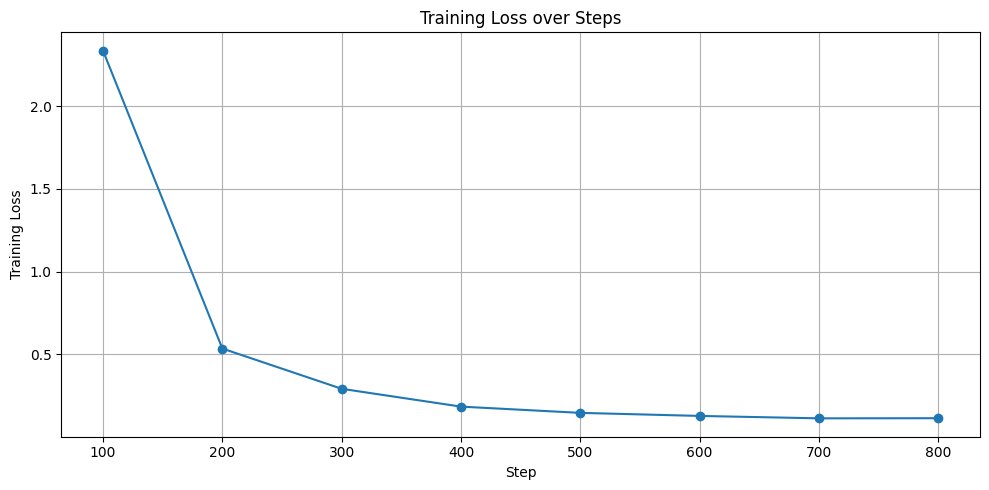

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Ambil data log dari state Trainer
log_history = trainer.state.log_history

# Konversi ke DataFrame untuk visualisasi
df_logs = pd.DataFrame(log_history)

# Filter hanya data loss (beberapa log mungkin untuk eval_loss, learning_rate, etc.)
train_loss = df_logs[df_logs['loss'].notnull()]

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss["step"], train_loss["loss"], marker='o')
plt.xlabel("Step")
plt.ylabel("Training Loss")
plt.title("Training Loss over Steps")
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# Simpan model dan tokenizer setelah training
trainer.save_model("models/llm_generator/Sentimen Publik/gpt2-kebijakan-sentimen-publik-500-finetuned")
tokenizer.save_pretrained("models/llm_generator/Sentimen Publik/gpt2-kebijakan-sentimen-publik-500-finetuned")

('models/llm_generator/Sentimen Publik/gpt2-kebijakan-sentimen-publik-500-finetuned/tokenizer_config.json',
 'models/llm_generator/Sentimen Publik/gpt2-kebijakan-sentimen-publik-500-finetuned/special_tokens_map.json',
 'models/llm_generator/Sentimen Publik/gpt2-kebijakan-sentimen-publik-500-finetuned/vocab.json',
 'models/llm_generator/Sentimen Publik/gpt2-kebijakan-sentimen-publik-500-finetuned/merges.txt',
 'models/llm_generator/Sentimen Publik/gpt2-kebijakan-sentimen-publik-500-finetuned/added_tokens.json')

In [15]:
# === Konfigurasi ===
MODEL_PATH = "models/llm_generator/Sentimen Publik/gpt2-kebijakan-sentimen-publik-500-finetuned"
DATA_PATH = "data/processed/Sentimen Publik/dataset_narasi_kebijakan_sentimen.txt"
DEVICE = "cpu"  # Ubah ke 'cuda' jika pakai GPU
MAX_SAMPLES = 10  # Batasi jumlah sampel untuk prediksi

# === Load Model dan Tokenizer ===
def load_model_and_tokenizer(model_path, device="cpu"):
    print(f"🚀 Loading model from: {model_path}\n")
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(model_path)
    model.to(device)
    print("✅ Model dan tokenizer berhasil dimuat.")
    return model, tokenizer

# === Load Kesimpulan dari File ===
def load_kesimpulan(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File tidak ditemukan: {file_path}")
    
    kesimpulan_list = []
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    
    entries = text.strip().split('\n\n')
    for entry in entries:
        if "Kesimpulan:" in entry and "Rekomendasi Kebijakan:" in entry:
            try:
                kesimpulan = entry.split("Kesimpulan:")[1].split("Rekomendasi Kebijakan:")[0].strip()
                kesimpulan_list.append(kesimpulan)
            except IndexError:
                continue

    print(f"✅ Total kesimpulan yang berhasil dimuat: {len(kesimpulan_list)}\n")
    
    return kesimpulan_list

# === Generate Rekomendasi ===
def generate_rekomendasi(model, tokenizer, kesimpulan, device="cpu"):
    prompt = f"Kesimpulan: {kesimpulan}\nRekomendasi Penanganan:"
    inputs = tokenizer.encode_plus(prompt,
                                   return_tensors="pt",
                                   padding=True,
                                   truncation=True)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    output = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_new_tokens=100,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.7,
        pad_token_id=tokenizer.eos_token_id
    )

    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
    rekomendasi = decoded.replace(prompt, "").strip()
    return rekomendasi

# === Main ===
def main():
    model, tokenizer = load_model_and_tokenizer(MODEL_PATH, DEVICE)
    kesimpulan_list = load_kesimpulan(DATA_PATH)

    for i, kesimpulan in enumerate(kesimpulan_list[:MAX_SAMPLES]):
        rekomendasi = generate_rekomendasi(model, tokenizer, kesimpulan, DEVICE)
        print(f"🟦 KESIMPULAN ({i+1}):\n{kesimpulan}")
        print(f"🟩 REKOMENDASI:\n{rekomendasi}")
        print("=" * 100)

if __name__ == "__main__":
    main()

🚀 Loading model from: models/llm_generator/Sentimen Publik/gpt2-kebijakan-sentimen-publik-500-finetuned

✅ Model dan tokenizer berhasil dimuat.
✅ Total kesimpulan yang berhasil dimuat: 500

🟦 KESIMPULAN (1):
Pandangan masyarakat terhadap sektor pengurusan administrasi kependudukan bersifat netral. Sebagian besar tanggapan menunjukkan sikap yang tidak condong kuat ke arah positif atau negatif, seperti: Masyarakat tidak terlalu mempermasalahkan proses yang ada, namun juga tidak menunjukkan antusiasme.
🟩 REKOMENDASI:
Tingkatkan komunikasi, akses, dan kualitas agar persepsi publik menjadi lebih positif.

Kesimpulan: Pandangan masyarakat terhadap sektor pengurusan administrasi kependudukan bersifat netral. Sebagian besar tanggapan menunjukkan sikap yang tidak condong kuat ke a
🟦 KESIMPULAN (2):
Sentimen publik terhadap sektor transportasi publik tergolong negatif. Respons warga mengindikasikan adanya ketidakpuasan, misalnya: Pengemudi dinilai kurang ramah dan tidak disiplin.
🟩 REKOMENDASI:
